In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pickle

import scipy.stats
import sklearn.metrics.pairwise
import sklearn.mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA

import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

#Local imports
import autoencoder
import eer
%matplotlib inline

WARNING (theano.gof.cmodule): OPTIMIZATION WARNING: Theano was not able to find the default g++ parameters. This is needed to tune the compilation to your specific CPU. This can slow down the execution of Theano functions. Please submit the following lines to Theano's mailing list so that we can fix this problem:
 ['# 1 "<stdin>"\n', '# 1 "<built-in>"\n', '# 1 "<command-line>"\n', '# 1 "<stdin>"\n', 'Reading specs from /usr/lib/gcc-lib/amd64-unknown-openbsd6.2/4.2.1/specs\n', 'Target: amd64-unknown-openbsd6.2\n', 'Configured with: OpenBSD/amd64 system compiler\n', 'Thread model: posix\n', 'gcc version 4.2.1 20070719 \n', ' /usr/lib/gcc-lib/amd64-unknown-openbsd6.2/4.2.1/cc1 -E -quiet -v -\n', 'ignoring duplicate directory "/usr/include"\n', '#include "..." search starts here:\n', '#include <...> search starts here:\n', ' /usr/include\n', 'End of search list.\n']
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Preliminaries
------------

Read in the keystroke dataset (see https://www.cs.cmu.edu/~keystroke/) and verify some of its basic properties:

In [3]:
df = pd.read_csv('DSL-StrongPasswordData.csv')
assert(not df.isnull().any().any())
assert(len(df) == 51*400)
assert(len(df.columns) == 34)

To aid evaluation, create a variable which indexes each password entry, separately for each subject. (With 400 password entries, *total_rep* ranges from 0 to 399). Subsequent evaluation is based on the method described at  https://www.cs.cmu.edu/~keystroke/, where for a given subject we use the first 200 password entries as training data, taking the remaining 200 password entries as positive testing instances. We use the first 5 password entries of remaining 50 subjects as negative testing instances. We repeat the evaluation procedure for each of the 51 subjects, averaging performance across subjects.

In [5]:
df['total_rep'] = (df['sessionIndex'] - 1) * 50 + df['rep'] - 1
feature_names = [column for column in df.columns if any([c in column for c in {'H.', 'DD.', 'UD.'}])]
N_train_genuine = 200
N_test_impostor = 5

Evaluation setup and baseline
--------------------------

Based on the chosen evaluation procedure, define a function *evaluate_detector()* which evaluates a given anomaly detection method. Define the Euclidean distance from the centroid of training data as a baseline method. To quantify performance, use our own implementation of the qual error rate (EER), defined as the fixed point on the graph of false negative rate versus false positive rate. (The implementation is based on computing an ROC curve, i.e. the plot of true positive rate versus false positive rate.)

In [6]:
def euclidean_distance_from_centroid(train, test):
    return sklearn.metrics.pairwise.euclidean_distances(np.atleast_2d(np.mean(train, axis=0)), test).T

def evaluate_detector(df, detector_function, feature_names, save_scores=False):
    eer = []
    for i, subject in enumerate(set(df['subject'])):
        train = df[(df['subject'] == subject) & (df['total_rep'] < N_train_genuine)][feature_names]
        test = df[(df['subject'] == subject) & (df['total_rep'] >= N_train_genuine)][feature_names]
        test['is_genuine_user'] = True
        test = test.append(df[(df['subject'] != subject) & (df['total_rep'] < N_test_impostor)][feature_names])
        test['is_genuine_user'] = test['is_genuine_user'].fillna(value=False)
        
        assert(len(train) == N_train_genuine)
        assert((test['is_genuine_user'] == True).sum() == (df['subject'] == subject).sum() - N_train_genuine)
        assert((test['is_genuine_user'] == False).sum() == len(set(df['subject']) - {subject}) * N_test_impostor)

        test['anomaly_score'] = detector_function(np.array(train), np.array(test[feature_names]))        
        eer.append(eer.compute_eer(-1 * np.array(test['anomaly_score']), np.array(test['is_genuine_user'])))

        if save_scores:
            np.save('scores/userScores_{}.npy'.format(i), np.array(test['anomaly_score'][test['is_genuine_user'] == True]))
            np.save('scores/impostorScores_{}.npy'.format(i), np.array(test['anomaly_score'][test['is_genuine_user'] == False]))
    return np.mean(eer), np.std(eer)

To help verify correctness, obatin the EER for the baseline method:

In [7]:
print('Baseline (Euclidean distance from centroid) EER: Mean {} Std {}'.format(*evaluate_detector(df, euclidean_distance_from_centroid, feature_names)))

Baseline (Euclidean distance from centroid) EER: Mean 0.17062745098 Std 0.0942570454608


As observed, the obatined value closely matches the value reported by Killourhy and Maxion for the '*Euclidean*' method https://www.cs.cmu.edu/~keystroke/.

Exploratory analysis
------------------

Next, with a view to training a model, for a single subject *'s002'* and based on kernel density estimation (KDE) we explore the marginal distribution of each of the variables in the dataset:

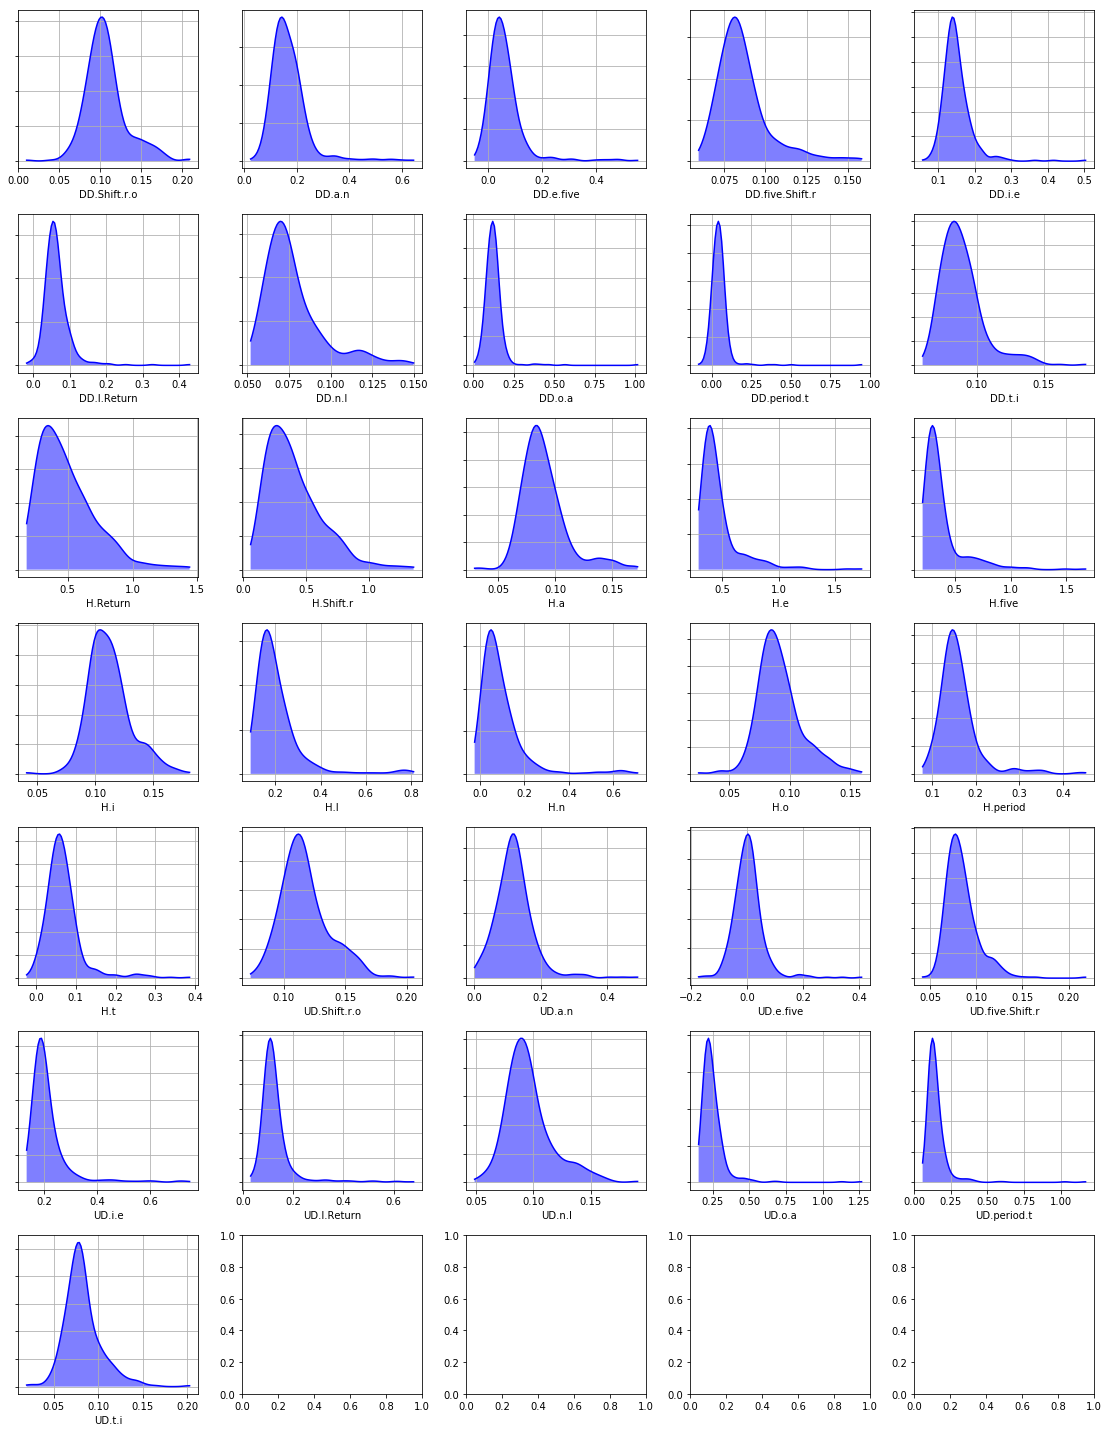

In [9]:
def plot_feature_kdes(data, feature_names, nrows=7, ncols=5, figsize=(15.5,20)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = np.ravel(axs)
    N_points = 100
    for i, feature in enumerate(sorted(feature_names)):
        x = np.linspace(np.min(data[:,i]), np.max(data[:,i]), N_points)
        kde1 = scipy.stats.kde.gaussian_kde(data[:,i])
        y1 = kde1(x)

        axs[i].plot(x, y1, 'b')
        axs[i].fill_between(x, 0, y1, facecolor='blue', alpha=0.5)    
        axs[i].grid(True)
        axs[i].set_xlabel(feature)
        for label in axs[i].get_yticklabels():
            label.set_visible(False)
    plt.tight_layout()
    plt.show()
plot_feature_kdes(np.array(df[df['subject'] == 's002'][feature_names]), feature_names)

According to the obtained plots, the majority of marginal distributions are asymetric and unimodal. Marginal distributions such as '*H.Return*', '*H.Shift.r*' appear to be relatively skewed. Whereas outliers appear to be present (e.g. '*H.t*', '*DD.period.t*'), based on visual inspaction they appear to be within one order magnitude relative to the standard deviation, hence relatively small.

Based on Pearson's r, explore pairwise correlations between features:

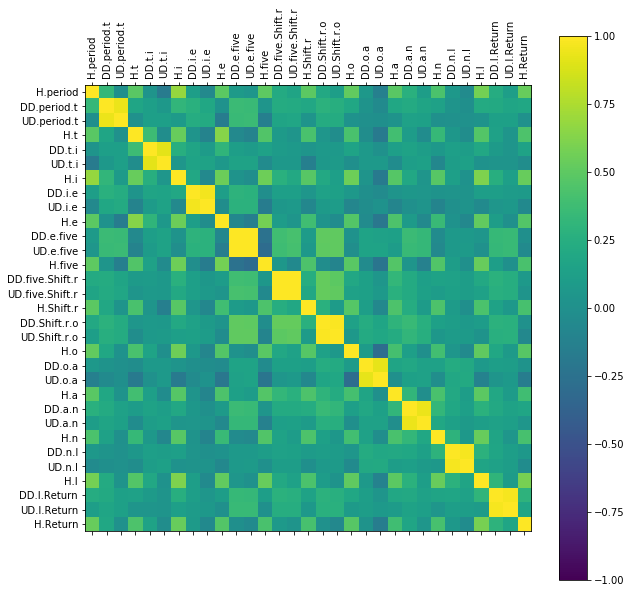

In [187]:
corr = df[df['subject'] == 's002'][feature_names].corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(feature_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticklabels(feature_names)
plt.show()

As observed, a large number of features exhibit correlations exceeding 0.50. This observation matches our expectation that features are redundant: For example, we would expect feature subsets to be linearly correlated with latent 'tempo', 'keypress duration' features, and thus correlated amongst themselves.

Gaussian mixture model evaluation
------------------------------

Next, train a Gaussian mixture model to predict impostors. Wwe obtain an anomaly score for a given instance using the estimated probability density associated with the instance, under the obtained GMM.

As independent variables, we consider the number of Gaussians (ranging from 1 to 7), and the type of covariance matrix estimated for each Gaussian (full or diagonal). Since assuming diagonal covariance for each Gaussian potentially discards information about correlated features, we evaluate the effect of transforming features in a preprocessing step, with a view to decorrelating variables. (To this end, we consider alternatively principal component analysis (PCA) and kernel principal component analysis (KPCA), where we vary the number of components used in the transformation). On the other hand, assuming Gaussians with full covariance potentially leads to an overly complex model, which might result in overfitting. In the latter case, it might be advantageous to transform features with a view to reducing feature dimensionality. In this way, by applying an initial feature transformation step we attempt to explore the relationship between model complexity and performance.

In [11]:
def density_gmm(train, test, transformer, n_gaussians, covariance_type, scaler=preprocessing.StandardScaler()):
    scaler = scaler.fit(train)
    train = scaler.transform(train)
    if transformer is not None:
        transformer = transformer.fit(train)
        train = transformer.transform(train)
    gmm = sklearn.mixture.GaussianMixture(n_components=n_gaussians, covariance_type=covariance_type, tol=0.001, reg_covar=1e-06, max_iter=100, n_init=5, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=64, warm_start=False, verbose=0, verbose_interval=10)
    gmm.fit(train)
    
    test = scaler.transform(test)
    if transformer is not None:
        test = transformer.transform(test)
    scores = gmm.score_samples(test)
    
    return -1 * scores

In [12]:
with open('gmm_results.pickle', 'rb') as f:
    results_EER_mean, results_EER_std = pickle.load(f)

In [ ]:
results_EER_mean = {}
results_EER_std = {}
for transformer_name in (None, 'pca', 'kpca'):
    results_EER_mean[transformer_name] = {}
    results_EER_std[transformer_name] = {}    
    if transformer_name == 'pca':
        max_components = len(feature_names)
    elif transformer_name == 'kpca':
        max_components = 2 * len(feature_names)
    else:
        max_components = 1
    for n_gaussians in (1,2,3,4,5,6,7):      
        for covariance_type in ('diag','full'):          
            for n_components in range(1,max_components+1):
                if transformer_name == 'pca':
                    eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_gmm(train, test, PCA(n_components=n_components, random_state=64), n_gaussians, covariance_type), feature_names)                        
                elif transformer_name == 'kpca':
                    eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_gmm(train, test, KernelPCA(kernel='sigmoid', n_components=n_components, random_state=64), n_gaussians, covariance_type), feature_names)
                else:
                    eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_gmm(train, test, transformer_name, n_gaussians, covariance_type), feature_names)
                results_EER_mean[transformer_name][(n_gaussians,covariance_type,n_components)] = eer_mean
                results_EER_std[transformer_name][(n_gaussians,covariance_type,n_components)] = eer_std
                print(str(transformer_name)+str(n_gaussians)+covariance_type+str(n_components) + ' ' + str(eer_mean))
with open('gmm_results.pickle', 'wb') as f:
    pickle.dump((results_EER_mean, results_EER_std), f)

Plot the obtained EERs separately for each Gaussian covariance type / feature transformer combination. For the case where no feature transformations is applied, plot EER in response to the number of Gaussians only. For the cases where PCA or KPCA is applied, plot EER in response to the number of Gaussians, as well as the number of components used in the transformation. (In the plots, error bars denote standard errors).

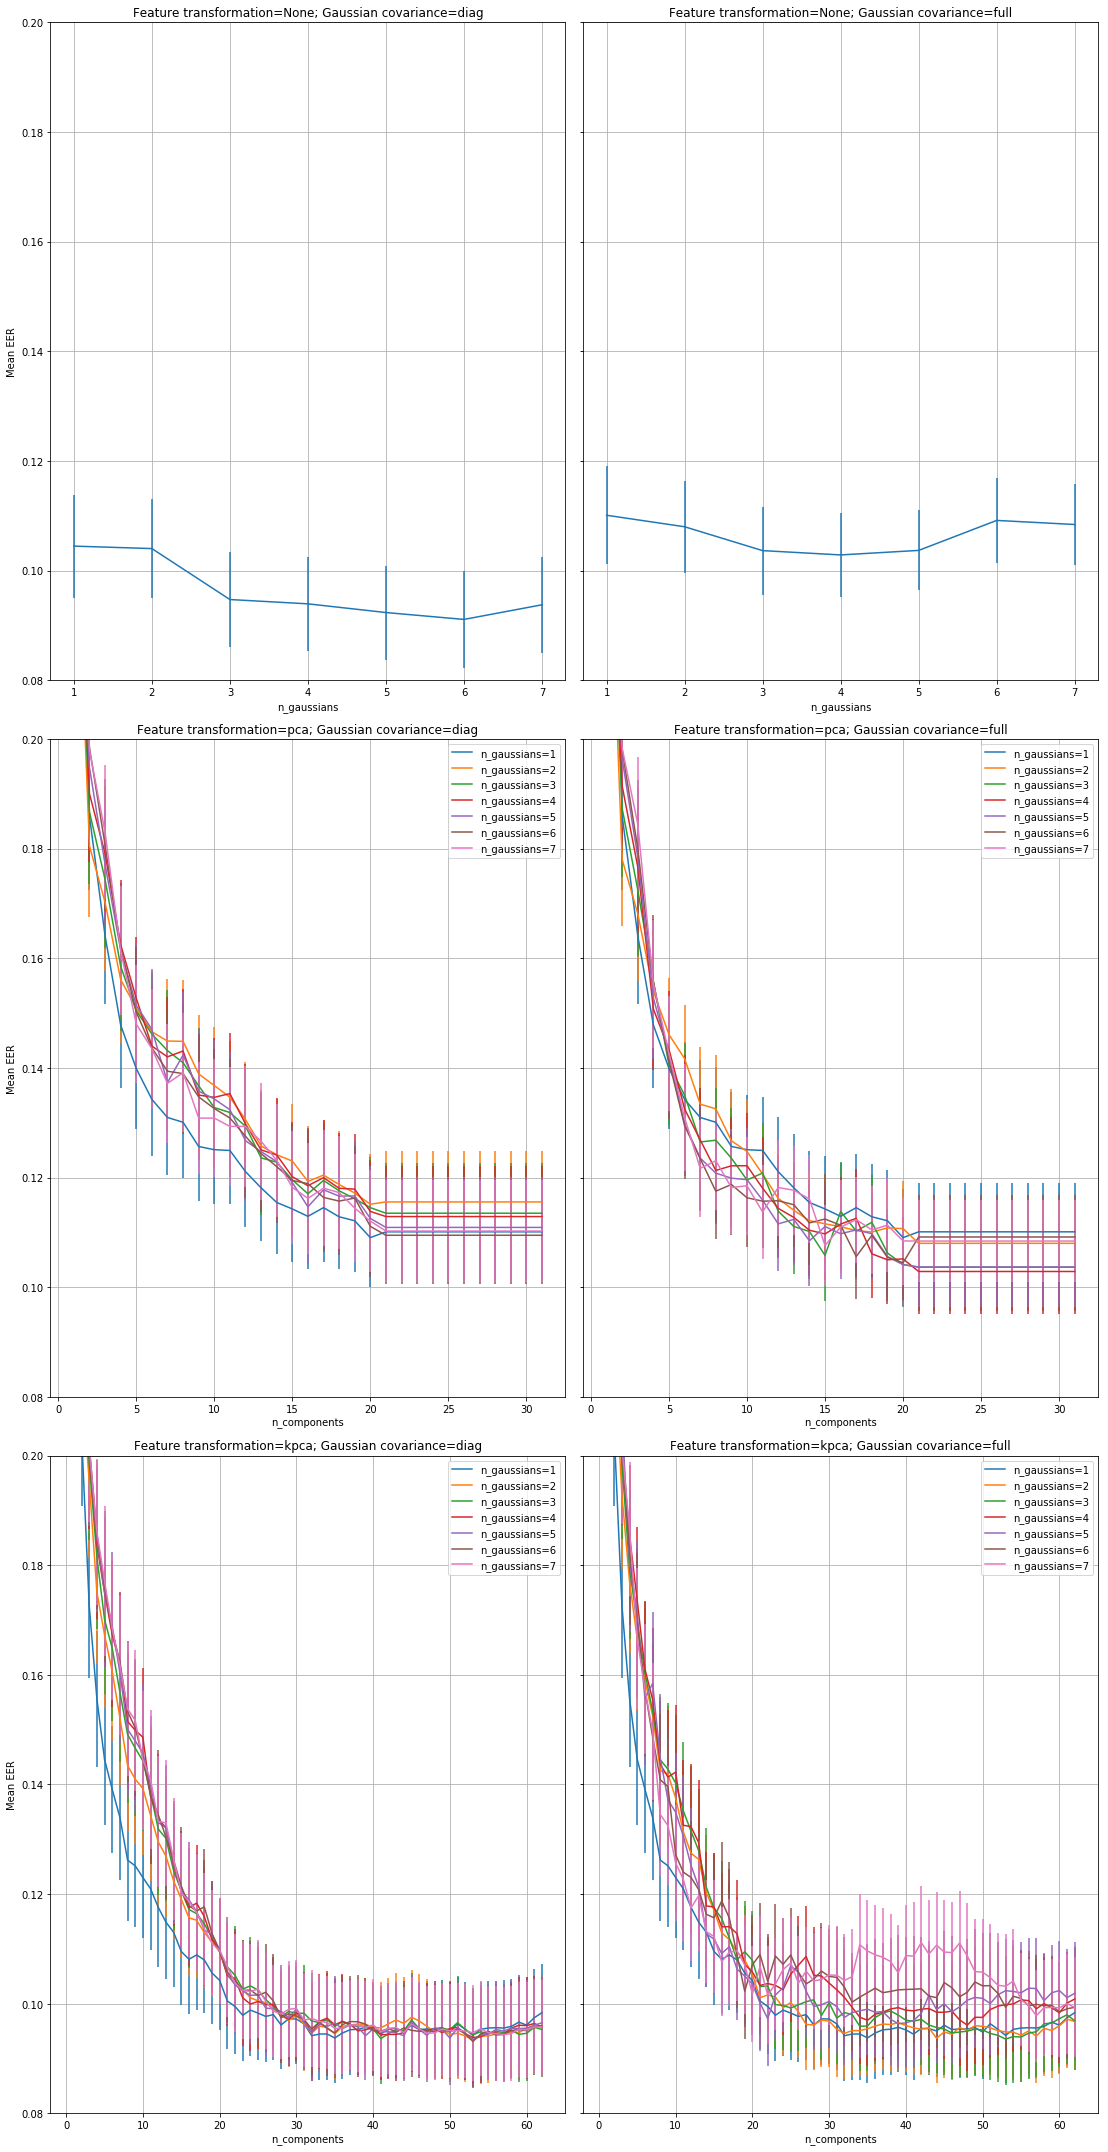

In [13]:
fig, axs = plt.subplots(nrows=len(results_EER_mean.keys()), ncols=2, figsize=(15.5,30))
for i, transformer_name in enumerate(results_EER_mean.keys()):
    df_results_EER_mean = DataFrame.from_dict(results_EER_mean[transformer_name], orient='index')
    df_results_EER_mean.columns = ('Mean EER',)
    df_results_EER_std = DataFrame.from_dict(results_EER_std[transformer_name], orient='index')
    df_results_EER_std.columns = ('Std EER',)
    df_results = df_results_EER_mean.join(df_results_EER_std)
    df_results.index = pd.MultiIndex.from_tuples(df_results.index, names=('n_gaussians', 'covariance_type','n_components'))
    df_results = df_results.reset_index()
    df_results['Standard error'] = df_results['Std EER'] / np.sqrt(len(set(df['subject'])))

    if transformer_name == None:
        for j, (name, group) in enumerate(df_results.groupby(['covariance_type'])):
            group = group.sort_values(by='n_gaussians')
            group.plot(x='n_gaussians', y='Mean EER', ax=axs[i, j], legend=False, fig=fig, yerr='Standard error', sharey=True, ylim=[0.08, 0.20])
            axs[i, j].set_ylabel('Mean EER')
            axs[i, j].set_title('Feature transformation=' + str(transformer_name) + '; Gaussian covariance=' + name)
    else:
        for j, (name, group) in enumerate(df_results.groupby(['n_gaussians', 'covariance_type'])):
            group = group.sort_values(by='n_components')
            #name = str(name).replace('(', 'n_gaussians=').replace(' ', ' covariance=')
            group.plot(x='n_components', y='Mean EER', ax=axs[i, j % 2], label='n_gaussians=' + str(name[0]), fig=fig, yerr='Standard error', sharey=True, ylim=[0.08, 0.20])
            axs[i, j % 2].set_ylabel('Mean EER')
            axs[i, j % 2].set_title('Feature transformation=' + str(transformer_name) + '; Gaussian covariance=' + name[1])            
for ax in list(np.ravel(axs)):
    ax.grid(True)
plt.tight_layout()
plt.show()

For each transformation method, report the best-performing approach:

In [203]:
for k in results_EER_mean.keys():
    print('Feature transformation %s: EER %f' % (k, min([np.min(v) for v in results_EER_mean[k].values()])))

Feature transformation None: EER 0.091098
Feature transformation pca: EER 0.102863
Feature transformation kpca: EER 0.093118


Kernel density estimation evaluation
--------------------------------

As an alternative to GMMs, we consider an analogous approach using KDE. We consider KDE using a Gaussian kernel, where we heuristically set the bandwidth parameter using Scott's rule. As was previously applied for GMMs, we consider a feature transformation step which aims at decorrelating features, and potentially dimensionality reduction.

As was performed for GMMs, we vary the method and number of components used to transform features:

In [15]:
def density_kde(train, test, transformer):
    scaler = preprocessing.StandardScaler().fit(train)
    train = scaler.transform(train)
    if transformer is not None:
        transformer = transformer.fit(train)
        train = transformer.transform(train)
    
    kde1 = scipy.stats.kde.gaussian_kde(train.T)
    
    test = scaler.transform(test)
    if transformer is not None:
        test = transformer.transform(test)
    
    scores = kde1.logpdf(test.T)
    scores[~np.isfinite(scores)] = -1E6
    
    return -1 * scores

In [16]:
with open('kde_results.pickle', 'rb') as f:
    results_kde_EER_mean, results_kde_EER_std = pickle.load(f)

In [ ]:
results_kde_EER_mean = {}
results_kde_EER_std = {}
for transformer_name in (None, 'pca', 'kpca'):
    results_kde_EER_mean[transformer_name] = {}
    results_kde_EER_std[transformer_name] = {}
    if transformer_name == 'pca':
        max_components = len(feature_names)
    elif transformer_name == 'kpca':
        max_components = 2 * len(feature_names)
    else:
        max_components = 1
    for n_components in range(1,max_components+1):
        if transformer_name == 'pca':
            eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_kde(train, test, PCA(n_components=n_components, random_state=64)), feature_names)
        elif transformer_name == 'kpca':
            eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_kde(train, test, KernelPCA(kernel='sigmoid', n_components=n_components, random_state=64)), feature_names)
        else:
            eer_mean, eer_std = evaluate_detector(df, lambda train, test: density_kde(train, test, transformer_name), feature_names)
        results_kde_EER_mean[transformer_name][n_components] = eer_mean
        results_kde_EER_std[transformer_name][n_components] = eer_std
        print(str(transformer_name)+str(n_components) + ' ' + str(eer_mean))
with open('kde_results.pickle', 'wb') as f:
    pickle.dump((results_kde_EER_mean, results_kde_EER_std), f)

Plot the obtained EERs separately for each feature transformer. For the case where no feature transformations is applied, plot EER only. For the cases where PCA or KPCA is applied, plot EER in response to the number of components used in the transformation. (In the plots, error bars denote standard errors).

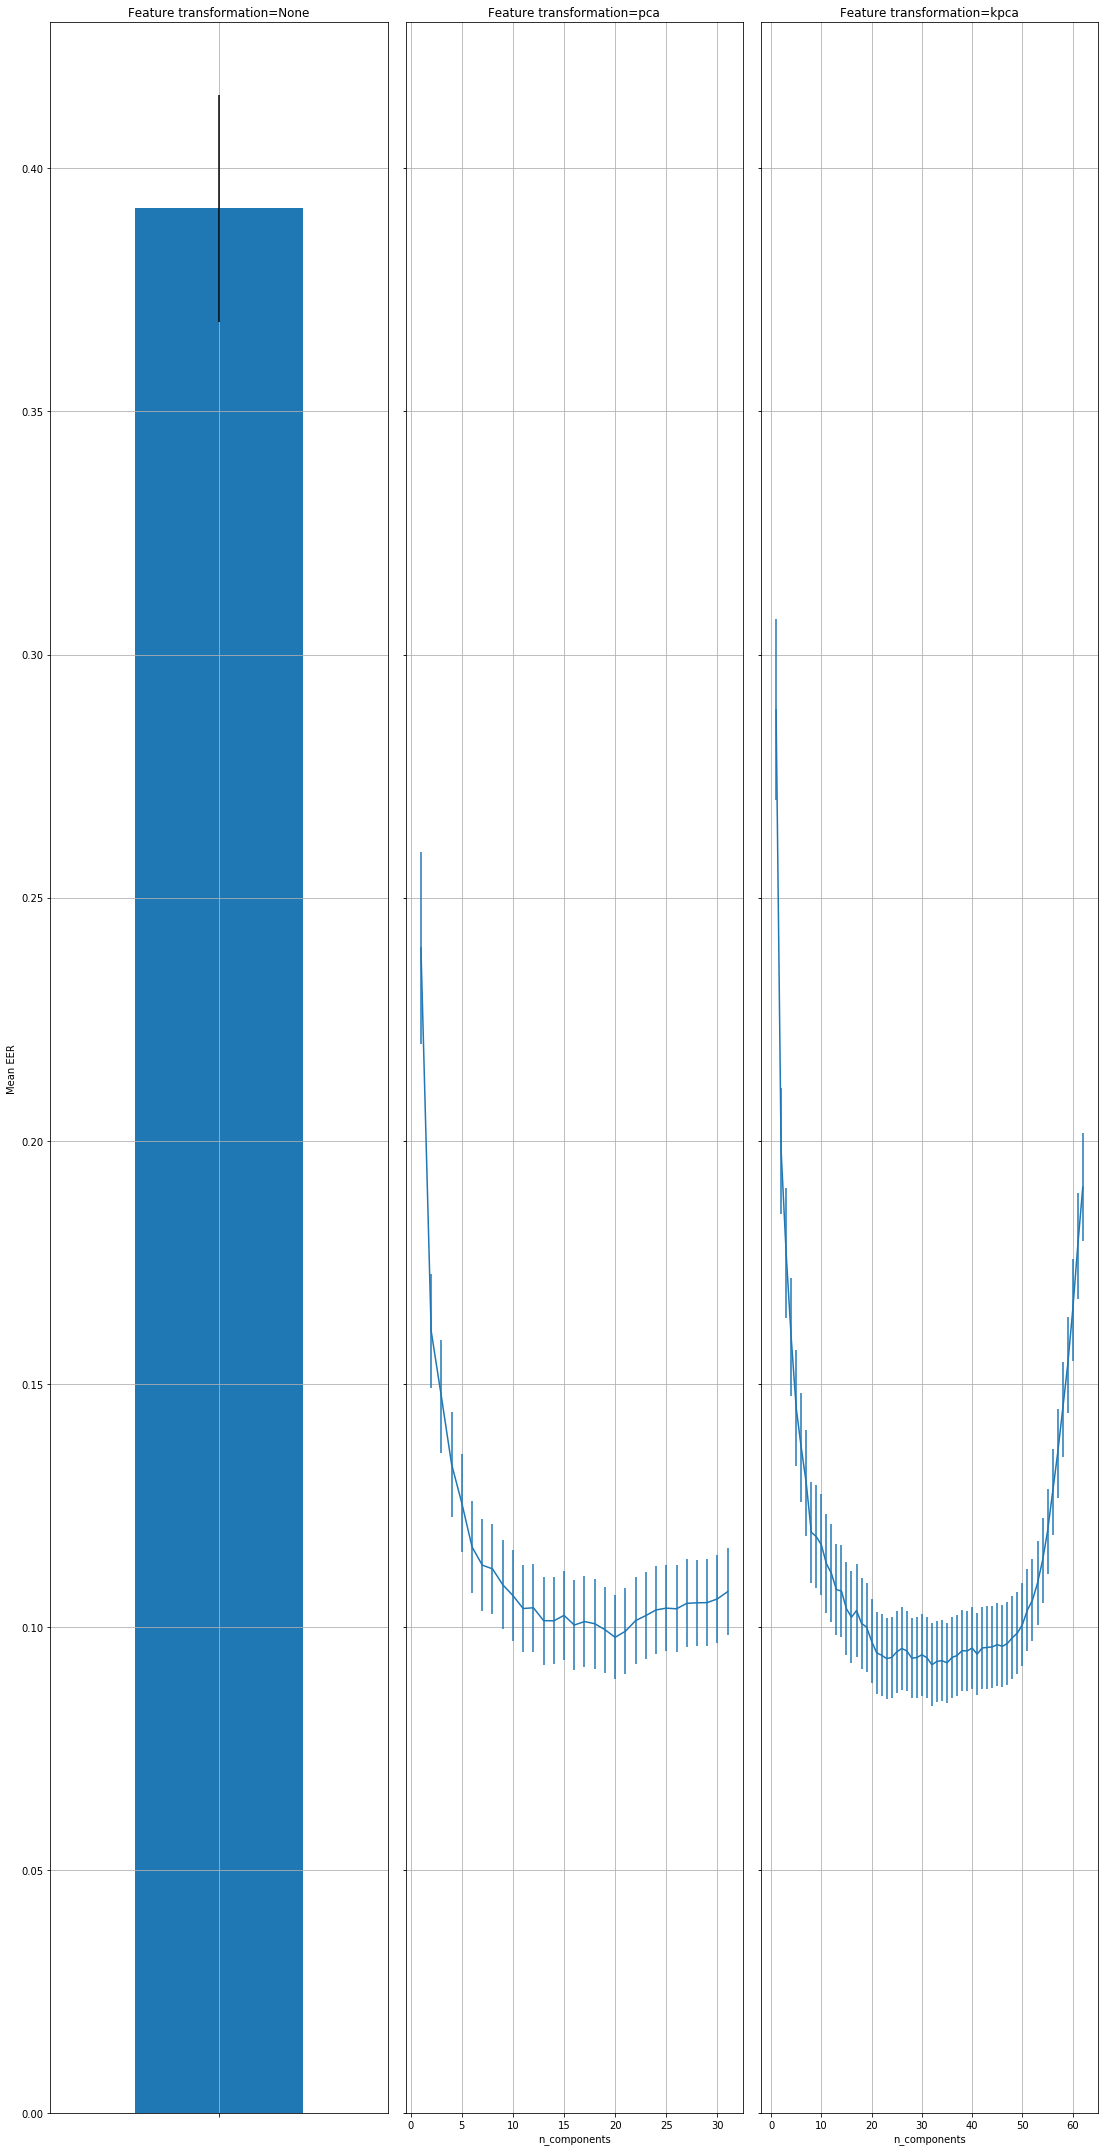

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5,30))
for i, transformer_name in enumerate(results_kde_EER_mean.keys()):
    df_results_kde_EER_mean = DataFrame.from_dict(results_kde_EER_mean[transformer_name], orient='index')
    df_results_kde_EER_mean.columns = ('Mean EER',)
    df_results_kde_EER_std = DataFrame.from_dict(results_kde_EER_std[transformer_name], orient='index')
    df_results_kde_EER_std.columns = ('Std EER',)
    df_results = df_results_kde_EER_mean.join(df_results_kde_EER_std)
    df_results.index.name = 'n_components'
    df_results = df_results.reset_index()
    df_results['Standard error'] = df_results['Std EER'] / np.sqrt(len(set(df['subject'])))
    df_results.sort_values(by='n_components')

    if transformer_name == None:
        df_results.plot(kind='bar', x='n_components', y='Mean EER', ax=axs[i], legend=False, fig=fig, yerr='Standard error', sharey=True, ylim=[0.00, 0.43])
        axs[i].set_ylabel('Mean EER')
        axs[i].set_xlabel('')
        for label in axs[i].get_xticklabels():
            label.set_visible(False)
        axs[i].set_title('Feature transformation=' + str(transformer_name))
    else:
        df_results.plot(x='n_components', y='Mean EER', ax=axs[i], legend=False, fig=fig, yerr='Standard error', sharey=True, ylim=[0.00, 0.43])
        axs[i].set_ylabel('Mean EER')
        axs[i].set_title('Feature transformation=' + str(transformer_name))            
for ax in list(np.ravel(axs)):
    ax.grid(True)
plt.tight_layout()
plt.show()

For each transformation method, report the best-performing approach:

In [204]:
for k in results_kde_EER_mean.keys():
    print('Feature transformation %s: EER %f' % (k, min([np.min(v) for v in results_kde_EER_mean[k].values()])))

Feature transformation None: EER 0.391745
Feature transformation pca: EER 0.097902
Feature transformation kpca: EER 0.092255


Autoencoder evaluation
--------------------

As a third approach, train an autoencoder, which we may use to reconstruct a given instance. Since an autoencoder aims at reconstructing a signal via an intermediate, compressed representation, and based on assuming that learnt representations accurately encode features for the legitimate user, but are less efficient at encoding features for imposter users, we use the reconstruction error of a given instance as our anomaly score.

Since training data are relatively scarce (100s of observations), we consider an autoencoder with a single hidden layer. The autoencoder is trained using stochastic gradient descent, based on optimising the mean squared error of reconstucted input, evaluated usig a separate validation subset obtained from 30% of provided training data. To aid convergence, we pre-process feaures by applying PCA whitening and re-scaling each resulting feature to unit range. To help prevent the autoencoder from learning the identify function, we impose a sparsity penalty on hidden activations. The sparsity penalty is based on computing the entropy of normalised activations, averaged across mini-batch instances.

As an independent variable, we scale the sparsity term. For the purpose of this evaluation, to limit execution time we set the number of hidden units constant, to 40.

The code for the autoencoder was adapted from the denoising autoencoder code available at http://deeplearning.net/tutorial/code/dA.py. We retain sigmoid activations and tied weights, re-writing the cost function to include squared reconstruction error and sparsity terms, while disregarding de-noising functionality. 

In [162]:
def test_dA(train, test, n_hidden=10, lamb=0, learning_rate=0.5, batch_size=10, max_epochs_without_change=20, tol=1E-02):
    pca=PCA(whiten=True, random_state=64).fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    
    scaler = preprocessing.MinMaxScaler().fit(train)
    train = scaler.transform(train)
    train, validate = sklearn.model_selection.train_test_split(train, test_size=0.33, random_state=576)
    test = scaler.transform(test)
    
    n_train = train.shape[0]
    n_train_batches = train.shape[0] // batch_size
    index = T.lscalar() # index for a mini-batch
    x = T.matrix('x')
    rng = np.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    da = autoencoder.dA(
        numpy_rng=rng,
        theano_rng=theano_rng,
        input=x,
        n_visible=train.shape[1],
        n_hidden=n_hidden,
        lamb=lamb
    )
    cost, updates = da.get_cost_updates(learning_rate=learning_rate)
    
    train = theano.shared(value=train, name='train', borrow=True)    
    train_da = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train[index * batch_size: (index + 1) * batch_size]
        }
    )

    # iterate through training epochs
    c_mean = 0.0
    i = epoch = 0
    while i < max_epochs_without_change:
        # iterate through batches
        for batch_index in range(n_train_batches):
            train = train[np.random.permutation(n_train), :]
            train_da(batch_index)
            
        # Evaluate against validation set
        c_mean_old = c_mean
        c_mean = np.mean(np.sum((validate - da.get_transcoder().eval({da.x: validate})) ** 2, axis=1))
        #if epoch % 10 == 0:
        #    print('Training epoch %d, cost %f' % (epoch, c_mean))
        if np.abs(c_mean - c_mean_old) / c_mean_old < tol:
            i += 1
        else:
            i = 0
        epoch += 1
    print('Training epoch %d, cost %f' % (epoch, c_mean))
    
    scores = np.sum((test - da.get_transcoder().eval({da.x: test})) ** 2, axis=1)
    return scores

In [ ]:
with open('ae_results.pickle', 'rb') as f:
    results_kde_EER_mean, results_kde_EER_std = pickle.load(f)

In [169]:
results_ae_EER_mean = {}
results_ae_EER_std = {}
for n_hidden_units in (60,):
    for lamb in np.linspace(1, 10, 20):
        eer_mean, eer_std = evaluate_detector(df, lambda train, test: test_dA(train, test, n_hidden=n_hidden_units, lamb=lamb), feature_names)
        results_ae_EER_mean[(n_hidden_units, lamb)] = eer_mean
        results_ae_EER_std[(n_hidden_units, lamb)] = eer_std
        print(str(n_hidden_units) + ' ' + str(lamb) + ' ' + str(eer_mean))
with open('ae_results.pickle', 'wb') as f:
    pickle.dump((results_ae_EER_mean, results_ae_EER_std), f)

Training epoch 76, cost 0.047934
Training epoch 97, cost 0.039557
Training epoch 80, cost 0.044866
Training epoch 65, cost 0.080919
Training epoch 77, cost 0.044684
Training epoch 82, cost 0.062662
Training epoch 92, cost 0.030637
Training epoch 72, cost 0.053547
Training epoch 77, cost 0.059668
Training epoch 94, cost 0.042426
Training epoch 90, cost 0.049578
Training epoch 88, cost 0.043489
Training epoch 87, cost 0.047148
Training epoch 84, cost 0.039407
Training epoch 75, cost 0.048107
Training epoch 78, cost 0.050771
Training epoch 85, cost 0.045952
Training epoch 88, cost 0.045399
Training epoch 86, cost 0.050885
Training epoch 92, cost 0.041097
Training epoch 94, cost 0.029326
Training epoch 92, cost 0.022106
Training epoch 100, cost 0.029419
Training epoch 79, cost 0.055053
Training epoch 81, cost 0.045555
Training epoch 81, cost 0.053121
Training epoch 86, cost 0.053098
Training epoch 84, cost 0.048762
Training epoch 78, cost 0.050519
Training epoch 82, cost 0.039749
Training 

Training epoch 65, cost 0.060556
Training epoch 55, cost 0.076771
Training epoch 54, cost 0.075161
Training epoch 66, cost 0.051756
Training epoch 66, cost 0.064210
Training epoch 62, cost 0.077071
Training epoch 60, cost 0.083455
Training epoch 52, cost 0.092844
Training epoch 69, cost 0.059160
Training epoch 60, cost 0.075891
60 2.89473684211 0.120568627451
Training epoch 51, cost 0.088439
Training epoch 50, cost 0.100190
Training epoch 44, cost 0.127142
Training epoch 32, cost 0.169996
Training epoch 56, cost 0.082161
Training epoch 58, cost 0.114426
Training epoch 62, cost 0.068625
Training epoch 52, cost 0.092125
Training epoch 52, cost 0.106483
Training epoch 57, cost 0.100841
Training epoch 48, cost 0.109418
Training epoch 54, cost 0.100975
Training epoch 56, cost 0.100670
Training epoch 61, cost 0.076480
Training epoch 51, cost 0.087291
Training epoch 57, cost 0.089629
Training epoch 50, cost 0.098468
Training epoch 54, cost 0.096078
Training epoch 53, cost 0.108916
Training ep

Training epoch 31, cost 0.121019
Training epoch 44, cost 0.130349
Training epoch 29, cost 0.176336
Training epoch 34, cost 0.151397
Training epoch 39, cost 0.111407
Training epoch 39, cost 0.132195
Training epoch 43, cost 0.126076
Training epoch 35, cost 0.110130
Training epoch 33, cost 0.192674
Training epoch 40, cost 0.148000
Training epoch 35, cost 0.136186
Training epoch 45, cost 0.106978
Training epoch 35, cost 0.121017
Training epoch 31, cost 0.119825
Training epoch 46, cost 0.090140
Training epoch 48, cost 0.110257
Training epoch 44, cost 0.121293
Training epoch 38, cost 0.139031
Training epoch 32, cost 0.142634
Training epoch 48, cost 0.107633
Training epoch 28, cost 0.179595
60 5.26315789474 0.120254901961
Training epoch 31, cost 0.134338
Training epoch 33, cost 0.150063
Training epoch 28, cost 0.191377
Training epoch 25, cost 0.225494
Training epoch 39, cost 0.130483
Training epoch 26, cost 0.311962
Training epoch 43, cost 0.117705
Training epoch 31, cost 0.145499
Training ep

Training epoch 31, cost 0.214570
Training epoch 33, cost 0.146996
Training epoch 34, cost 0.114316
Training epoch 31, cost 0.143944
Training epoch 27, cost 0.239246
Training epoch 28, cost 0.185069
Training epoch 29, cost 0.177819
Training epoch 31, cost 0.308217
Training epoch 30, cost 0.199593
Training epoch 29, cost 0.191520
Training epoch 32, cost 0.148725
Training epoch 27, cost 0.156260
Training epoch 31, cost 0.182945
Training epoch 39, cost 0.242198
Training epoch 28, cost 0.193912
Training epoch 29, cost 0.152149
Training epoch 29, cost 0.175400
Training epoch 30, cost 0.172457
Training epoch 27, cost 0.149945
Training epoch 29, cost 0.243113
Training epoch 29, cost 0.208979
Training epoch 28, cost 0.178505
Training epoch 30, cost 0.155618
Training epoch 29, cost 0.155442
Training epoch 27, cost 0.150877
Training epoch 32, cost 0.131030
Training epoch 31, cost 0.160640
Training epoch 32, cost 0.170576
Training epoch 29, cost 0.183638
Training epoch 28, cost 0.181099
Training e

Training epoch 26, cost 0.230181
Training epoch 25, cost 0.248488
Training epoch 26, cost 0.233191
Training epoch 26, cost 0.239609
Training epoch 25, cost 0.376369
Training epoch 29, cost 0.207050
Training epoch 42, cost 0.217971
Training epoch 26, cost 0.216676
Training epoch 35, cost 0.386761
Training epoch 27, cost 0.223809
Training epoch 26, cost 0.258099
Training epoch 36, cost 0.360260
Training epoch 27, cost 0.189107
Training epoch 29, cost 0.147329
Training epoch 27, cost 0.176763
Training epoch 38, cost 0.430806
Training epoch 26, cost 0.231008
Training epoch 26, cost 0.215785
Training epoch 37, cost 0.366145
Training epoch 27, cost 0.244381
Training epoch 32, cost 0.321569
Training epoch 28, cost 0.182504
Training epoch 39, cost 0.205420
Training epoch 27, cost 0.226176
Training epoch 42, cost 0.298324
Training epoch 37, cost 0.240058
Training epoch 26, cost 0.188084
Training epoch 26, cost 0.215915
Training epoch 26, cost 0.211597
Training epoch 25, cost 0.188890
Training e

Plot the obtained EERs in response to the sparsity coefficient:

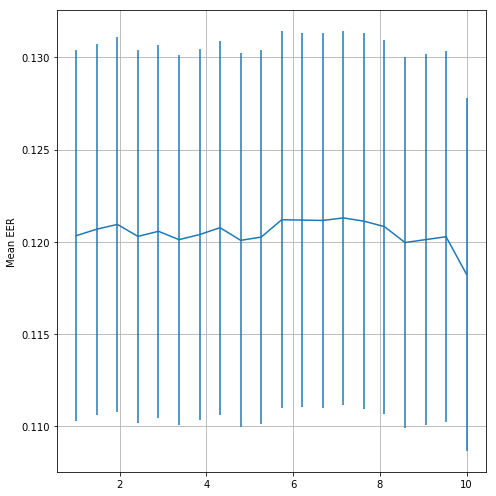

In [230]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
results_autoencoder = DataFrame([pd.Series(results_ae_EER_mean), pd.Series(results_ae_EER_std)]).T
results_autoencoder = results_autoencoder.reset_index()
results_autoencoder.columns = ('level 0', 'lambda', 'Mean EER', 'Standard error')
results_autoencoder['Standard error'] /= np.sqrt(len(set(df['subject'])))
results_autoencoder.plot(x='lambda', y='Mean EER', legend=False, yerr='Standard error', ax=axs)
axs.set_ylabel('Mean EER')
axs.set_xlabel('')
axs.grid(True)
plt.tight_layout()
plt.show()

Report the EER for the best-performing parameter value:

In [236]:
print('Best-performing EER %f' % min(results_ae_EER_mean.values()))

Best-performing EER 0.118235


Conclusions
----------

* Have evaluated 3 anomaly detection approaches against Killourhy and Maxion's keystoke dynamics dataset
* Based on reported EERs and the considered methodology, the best-performing approach yields an EER of 9.1%, obtained using a GMM with no feature transformation applied besides standardisation, and diagonal covariance
* Using KPCA in combination with KDE yields similar performance.
* Autoencoder yields worst performance among methods (NB: More extensive parameter search required, and comparison to identity function baseline)

* Critical note: Did not explore evaluation methodology. (Single evaluation metric with relatively small dataset). Further work required to determine statistical significance when comparing results.
* Moreover, initial exploration suggests that there is a learning effect in subjects' data. Possible to boost performance using a sampling technique, e.g. by filtering across time. Useful to compare performance using a different, larger dataset.
* Can we estimate optimal performance, e.g. by considering a binary classification task in place of anomaly detection?]
* Examine effect of hyper-parameters more closely and perform more extensive grid search for autoencoders
* Did not consider feature engineering